# Introduction

This project proposed by [Data Professor](https://www.youtube.com/channel/UCV8e2g4IWQqK71bbzGDEI4Q) aims to build models predicting molecules binding to the Beta-Lactamase protein. For the complete project description, see this [video](https://www.youtube.com/watch?v=_GtEgiWWyK4) on the [Data Professor](https://www.youtube.com/channel/UCV8e2g4IWQqK71bbzGDEI4Q) channel.  

* The EDA and data pre-processing were performed in the notebook [Beta-Lactamase_001_Data_Wrangling_and_EDA](https://www.kaggle.com/wguesdon/beta-lactamase-001-data-wrangling-and-eda/edit/run/83400192).
* Model baseline was performed in the notebook [Beta-Lactamase_002_classification_model](https://www.kaggle.com/wguesdon/beta-lactamase-002-classification-model)
* Models comparision were performed in the notebook [Beta-Lactamase_003_Classification_Pipeline](https://www.kaggle.com/wguesdon/beta-lactamase-003-classification-pipeline)
* This notebook contains the tunning of the selected model with the best performance.

In [1]:
##################
# I Initialization
##################

#+++++++++++++++
# Load libraries
#+++++++++++++++

import os
from pathlib import Path # for path in Windows and Unix
import zipfile
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

#+++++++++++++++++++
# Define Environment
#++++++++++++++++++

environemnt = 'kaggle'

#+++++++++++++++++++++++++++
# Define the working folders
#+++++++++++++++++++++++++++

# see https://careerkarma.com/blog/python-list-files-in-directory/
# See https://medium.com/@ageitgey/python-3-quick-tip-the-easy-way-to-deal-with-file-paths-on-windows-mac-and-linux-11a072b58d5f

if environemnt == 'kaggle':
    project_data_folder = Path('/kaggle/input/beta-lactamase-001-data-wrangling-and-eda/')
if environemnt == 'local':
    project_data_folder = Path('/home/will/Documents/Python/Beta_lactamase/Data/')
if environemnt == 'colab':
    project_data_folder = Path('/content/drive/MyDrive/Bioinformatics/Beta-lactamase/Data/')
    
#++++++++++++++++++++++++
# Load the processed data
#++++++++++++++++++++++++

file_path = project_data_folder / 'beta-lactamase_filtered_dataset.csv'
df = pd.read_csv(file_path)
df.head()

,molecule_chembl_id,canonical_smiles,standard_relation,standard_value,standard_units,standard_type,pchembl_value,target_pref_name,bao_label,Name,...,SubFP298,SubFP299,SubFP300,SubFP301,SubFP302,SubFP303,SubFP304,SubFP305,SubFP306,SubFP307
0,CHEMBL1401836,COc1ccc(CCNC(=O)CSCc2ccc(F)cc2)cc1OC,=,79432.8,nM,Potency,4.10,Beta-lactamase AmpC,assay format,CHEMBL1401836,...,0,0,1,1,1,0,0,0,0,1
1,CHEMBL554891,Cl.c1ccc(C2CN3CCSC3=N2)cc1,=,631.0,nM,Potency,6.20,Beta-lactamase AmpC,assay format,CHEMBL554891,...,0,0,1,1,1,0,0,0,0,1
2,CHEMBL1519543,CCOc1ccc(CCNC(=O)Cn2ncn3c(cc4ccccc43)c2=O)cc1OCC,=,631.0,nM,Potency,6.20,Beta-lactamase AmpC,assay format,CHEMBL1519543,...,0,0,1,1,1,0,0,0,0,1
3,CHEMBL1401837,O=C(Nc1ccc2c(c1)OCO2)c1cc(C2CC2)on1,=,5623.4,nM,Potency,5.25,Beta-lactamase AmpC,assay format,CHEMBL1401837,...,0,0,1,1,1,0,0,0,0,1
4,CHEMBL2369239,CCCCCCOc1ccc(N2C(=O)CC(SC(=N)N/N=C(\C)c3cccs3)...,=,63095.7,nM,Potency,4.20,Beta-lactamase AmpC,assay format,CHEMBL2369239,...,0,0,1,1,1,0,0,0,0,1


In [2]:
#####################
# II Data preparation
#####################

#+++++++++++++++++++
# Feature enginering
#+++++++++++++++++++

# Drop content no useful for prediction
# canonical_smiles, standard_relation, standard_value, standard_units, 
# standard_type, target_pref_name, bao_label

columns_to_drop = ['canonical_smiles', 'standard_relation', 'standard_value', 'standard_units', 
                   'standard_type', 'target_pref_name', 'bao_label', 'Name', 'molecule_chembl_id']
df1 = df.drop(columns_to_drop, axis = 1)

# Recode pchembl_value	
# pChEMBL values <5 == 'Inactive' pChEMBL values > 6 == 'Active' pChEMBL values 5-6 == 'Intermediate'
# Inactive = 0
# Intermediate = 1
# Active = 2

def pchembl_value_encoding(pchembl_value):
    if pchembl_value < 5:
        return 'Inactive'
    elif pchembl_value > 5 and pchembl_value < 6:
        return 'Intermediate'
    else:
        return 'Active'

df1['pchembl_value_code'] = df1.apply(lambda row : pchembl_value_encoding(row['pchembl_value']), axis = 1)

df1 = df1.drop(['pchembl_value'], axis = 1)
df1.head()

,SubFP1,SubFP2,SubFP3,SubFP4,SubFP5,SubFP6,SubFP7,SubFP8,SubFP9,SubFP10,...,SubFP299,SubFP300,SubFP301,SubFP302,SubFP303,SubFP304,SubFP305,SubFP306,SubFP307,pchembl_value_code
0,0,1,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,1,Inactive
1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,1,Active
2,1,1,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,1,Active
3,0,1,1,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,1,Intermediate
4,1,1,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,1,Inactive


In [3]:
#++++++++++++++++++++++++++++++++++++++++++++
# Exclude molecule with intermediate activity
#++++++++++++++++++++++++++++++++++++++++++++

# see https://www.kaggle.com/sayalaruano/eda-fingerprint-calc-binary-classifiers/comments

df1 = df1[df1['pchembl_value_code'] != 'Intermediate']

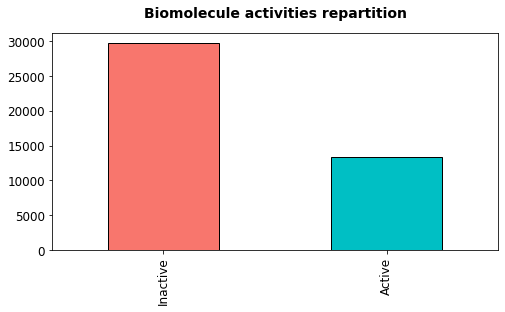

In [4]:
#+++++++++++++++++++++++
# activities repartition
#+++++++++++++++++++++++

pchembl_value_code = df1.pchembl_value_code.value_counts()
pchembl_value_code.plot.bar(figsize=(8,4), color = ['#F8766D', '#00BFC4'], ec='black')

plt.title('Biomolecule activities repartition', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [5]:
#+++++++++++++++++++++++++++++++++++++++++
# Split data into input and output objects
#+++++++++++++++++++++++++++++++++++++++++

from sklearn.utils import shuffle

X = df1.drop(['pchembl_value_code'], axis = 1)
y = df1['pchembl_value_code']
X, y = shuffle(X, y)

In [6]:
#++++++++++++++++++++++++++++++
# Remove low variance features
#++++++++++++++++++++++++++++++

# See https://dataprofessor.github.io/ds/bioinformatics/cheminformatics/padelpy/scikit-learn/2021/07/06/_07_06_padelpy.html#Load-HCV-dataset

from sklearn.feature_selection import VarianceThreshold

def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data[input_data.columns[selection.get_support(indices=True)]]

X = remove_low_variance(X, threshold=0.1)
X

,SubFP1,SubFP2,SubFP3,SubFP18,SubFP23,SubFP26,SubFP85,SubFP88,SubFP96,SubFP100,...,SubFP137,SubFP143,SubFP171,SubFP180,SubFP181,SubFP182,SubFP183,SubFP184,SubFP214,SubFP287
18453,0,1,1,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
33765,1,1,0,0,0,0,0,1,1,1,...,0,1,0,0,0,1,0,1,0,1
58875,0,1,0,0,0,0,0,1,1,1,...,0,0,1,0,0,0,1,1,0,0
54513,1,0,1,1,0,0,0,1,0,1,...,1,0,0,0,1,0,0,1,0,1
27719,0,1,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,0,1,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
52843,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
15957,1,1,0,0,0,0,0,1,0,1,...,0,1,0,0,1,1,0,1,0,0
24780,0,0,0,0,0,0,0,1,0,1,...,1,0,1,0,0,0,0,0,0,1


In [7]:
#########################
# III Random Forest model
#########################

# see Basic Code Stencil (PRACTICAL) Data Science infinity
# see https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# see https://medium.com/@benfenison/gridsearching-a-random-forest-classifier-fc225609699c

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

# Instanciate the grid search object
rf_grid = {"n_estimators" : [100, 150, 200, 250, 400, 500, 750, 100],
           "max_depth" : [None , 3 , 5 , 10],
           "min_samples_split" : np.arange(2 , 20 ,4),
           "min_samples_leaf" : np.arange(1 , 20 ,4)}

gscv = GridSearchCV(
    estimator = RandomForestClassifier(random_state=42),
    param_grid = rf_grid,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = -1
)

# Fit to data
gscv.fit(X_train, y_train)

# Get the best CV score
gscv.best_score_

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.6904382163535241

In [8]:
# Optimal parameters
gscv.best_params_

{'max_depth': None,
 'min_samples_leaf': 9,
 'min_samples_split': 2,
 'n_estimators': 200}

In [9]:
# Create optimal model object
clf = gscv.best_estimator_

# Train the optimal model
# Train our model
clf.fit(X_train, y_train)

# Assess the model accuracy
# see https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case

y_pred = clf.predict(X_test)

# Accuracy
print('accuracy score:', accuracy_score(y_test, y_pred))

# Precision
print('precision score:', precision_score(y_test, y_pred, average="macro"))

# Recall score
print('recall score:', recall_score(y_test, y_pred, average="macro"))

# F1 score
print('F1 score:',f1_score(y_test, y_pred, average="macro"))

accuracy score: 0.6904071453427677
precision score: 0.7201897412092375
recall score: 0.5004775538069964
F1 score: 0.40951031938147225


In [10]:
# Feature importance
result = permutation_importance(clf, X_test, y_test, n_repeats = 10, random_state = 42)

permutation_importance= pd.DataFrame(result["importances_mean"])
feature_names = pd.DataFrame(X.columns)
permutation_importance_summary = pd.concat([feature_names, permutation_importance], axis = 1)
permutation_importance_summary.columns = ["input_variable", "feature_importance"]
permutation_importance_summary.sort_values(by = "feature_importance", inplace=True)

# List the 20 top features
permutation_importance_summary.head(20)

,input_variable,feature_importance
13,SubFP143,-0.000023
17,SubFP182,0.000000
5,SubFP26,0.000000
7,SubFP88,0.000023
8,SubFP96,0.000023
2,SubFP3,0.000035
15,SubFP180,0.000046
10,SubFP101,0.000058
18,SubFP183,0.000070
0,SubFP1,0.000070
